In [1]:
from __future__ import absolute_import, division, print_function

import os
import random
from turtle import left
from matplotlib import pyplot as plt
import numpy as np
import csv
import json
import copy
from PIL import Image  # using pillow-simd for increased speed
import glob
from scipy.spatial.transform import Rotation

import torch
import torch.utils.data as data
from torchvision import transforms
import cv2
from tqdm import tqdm
from pytorch3d.transforms import axis_angle_to_matrix 
from torch.utils.data import ConcatDataset, WeightedRandomSampler, DataLoader

In [2]:
def rgb_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    frame = cv2.imread(path)
    return frame

In [3]:
def crop_img(img:np.ndarray, crop_height:int, crop_width:int)->np.ndarray:
    """create central crop for the image

    Args:
        img (np.ndarray): input image
        crop_height (np.ndarray): _description_
        crop_width (np.ndarray): _description_

    Returns:
        np.ndarray: central cropped image
    """
    height,width = img.shape[:2]
    top = (height - crop_height)//2
    left = (width - crop_width)//2
    bottom = (height + crop_height)//2
    right = (width + crop_width)//2

    return img[top:bottom,left:right,...]


In [4]:
class StereoPoseDataset(data.Dataset):
    def __init__(self, pose_gt_dir,
                       frames_dir,
                       datafile_path,
                       height,
                       width,
                       is_train,
                       use_quaternion) -> None:
        super(StereoPoseDataset,self).__init__()
        self.pose_gt_dir = pose_gt_dir
        self.frame_dir = frames_dir
        self.datafile_path = datafile_path
        self.use_quaternion = use_quaternion

        self.height = height
        self.width = width

        self.is_train = is_train

        self.rgb_loader = rgb_loader
        self.load_pose_json_data()

        self.data = []
        print('Reading training files information...')
        with open(self.datafile_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                self.data.append(row)

        # We need to specify augmentations differently in newer versions of torchvision.
        # We first try the newer tuple version; if this fails we fall back to scalars
        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.ColorJitter.get_params(
                self.brightness, self.contrast, self.saturation, self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

        self.to_tensor = transforms.ToTensor()

    def preprocess(self, inputs, color_aug):
        for k in list(inputs):
            if 'target' in k or 'reference' in k:
                inputs[k+'_aug'] = color_aug(inputs[k])

        for k in list(inputs):
            if 'target' in k or 'reference' in k:
                inputs[k] = self.to_tensor(inputs[k])

    def __getitem__(self, index):
        inputs = {}

        do_color_aug = self.is_train and random.random() > 0.5
        # do_flip = self.is_train and random.random() > 0.5

        dataset,week,capture,cam_type,target_cam_num,\
            ref_cam_num,left_frame_path, right_frame_path = self.data[index]

        # read calibration data
        dataset_key = f'{dataset}_{week}' if len(week) > 0 else dataset
        inputs['dataset'] = dataset_key
        
        left_frame_path = os.path.join(self.frame_dir,left_frame_path)
        right_frame_path = os.path.join(self.frame_dir,right_frame_path)

        left_img = self.rgb_loader(left_frame_path)
        right_img = self.rgb_loader(right_frame_path)

        pose = self.pose_gt[dataset_key][capture][cam_type]['extrinsics'][f'{target_cam_num}_{ref_cam_num}']
        R, t = np.array(pose['rmat']).reshape(3,3),np.array(pose['tvec']).reshape(3,)
        
        intr_left = self.pose_gt[dataset_key][capture][cam_type]['intrinsics'][str(target_cam_num)]
        intr_right = self.pose_gt[dataset_key][capture][cam_type]['intrinsics'][str(ref_cam_num)]
        K_left, dist_left = np.array(intr_left['K']).reshape(3,3),np.array(intr_left['dist']).reshape(-1)
        K_right, dist_right = np.array(intr_right['K']).reshape(3,3),np.array(intr_right['dist']).reshape(-1)

        # undistort left and right image
        left_undist_img = cv2.undistort(left_img, K_left, dist_left)
        right_undist_img = cv2.undistort(right_img, K_right, dist_right)

        # take center crop
        left = crop_img(left_undist_img, self.height, self.width)
        right = crop_img(right_undist_img, self.height, self.width)

        inputs['target'] = Image.fromarray(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        inputs['reference'] = Image.fromarray(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))

        if do_color_aug:
            color_aug = transforms.ColorJitter.get_params(self.brightness, self.contrast, self.saturation, self.hue)
        else:
            color_aug = (lambda x : x)

        self.preprocess(inputs, color_aug)

        inputs['rotation'] = Rotation.from_matrix(R).as_rotvec() if not self.use_quaternion else Rotation.from_matrix(R).as_quat()
        inputs['rotation'] = inputs['rotation'].astype(np.float32)
        inputs['axisangles'] = Rotation.from_matrix(R).as_rotvec(degrees=True).astype(np.float32)
        inputs['rmat'] = R.astype(np.float32)
        inputs['translation'] = t.astype(np.float32)

        return inputs

    def __len__(self):
        return len(self.data)

    def load_pose_json_data(self,del_intr_data = False):
        
        self.pose_gt = {}
        
        # scan for all the json files in the pose groundtruth dir
        json_fpaths = sorted(glob.glob(os.path.join(self.pose_gt_dir,'**','*.json'), recursive=True))

        # Read all json data in dictionary
        for json_fpath in json_fpaths:
            dataset = 'torc' if 'torc' in json_fpath else 'continental'
            week = json_fpath.split('/')[-2] if dataset == 'torc' else ''
            dataset_key = f'{dataset}_{week}' if len(week) > 0 else dataset 
            if dataset_key not in self.pose_gt.keys():
                self.pose_gt[dataset_key] = {}
            with open(json_fpath,'r') as fh:
                self.pose_gt[dataset_key].update(json.load(fh))
        


In [5]:
data_dir   = "/nas/EOS/users/aman/data/RelativePose/frames"
gt_dir     = "/nas/EOS/users/aman/data/RelativePose/groundtruth_json_poses"
splits_dir = "/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files"
height, width = 256, 512

In [6]:
train_dataset = StereoPoseDataset(gt_dir,data_dir,
                                  os.path.join(splits_dir,'train_dataset.csv'),
                                  height, width, True, False )
val_dataset = StereoPoseDataset(gt_dir,data_dir,
                                os.path.join(splits_dir,'val_dataset.csv'),
                                height, width, False, False)


Reading training files information...
Reading training files information...


In [ ]:
# Get all targets
targets = []
for input in tqdm(train_dataset):
    target = input['dataset']
    targets.append(target)
targets = np.array(targets)

In [8]:
input.keys()

dict_keys(['dataset', 'target', 'reference', 'target_aug', 'reference_aug', 'rotation', 'axisangles', 'rmat', 'translation'])

In [9]:
input['axisangles']

array([0.7165576 , 0.2527263 , 0.00211851], dtype=float32)

In [10]:
input['rotation']

array([1.2506290e-02, 4.4109058e-03, 3.6974954e-05], dtype=float32)

In [22]:
x = torch.tensor(input['axisangles'])
x.requires_grad = True

In [23]:
x

tensor([0.7166, 0.2527, 0.0021], requires_grad=True)

In [25]:
rmat_pred = axis_angle_to_matrix(x.reshape(-1,3))

In [30]:
rmat_pred

tensor([[[ 0.9696,  0.0844,  0.2298],
         [ 0.0882,  0.7554, -0.6493],
         [-0.2284,  0.6498,  0.7250]]], grad_fn=<ViewBackward>)

In [ ]:
def gram_schmidt(m):
  """Convert 6D representation to SO(3) using a partial Gram-Cchmidt process.
  Args:
    m: [BATCH, 2, 3] 2x3 matrices.
  Returns:
    [BATCH, 3, 3] SO(3) rotation matrices.
  """
  x  = m[:, 0]
  y  = m[:, 1]
  xn = tf.math.l2_normalize(x, axis=-1)
  z  = tf.linalg.cross(xn, y)
  zn = tf.math.l2_normalize(z, axis=-1)
  y  = tf.linalg.cross(zn, xn)
  r  = tf.stack([xn, y, zn], 1)
  return r

In [37]:
a = torch.randn(5,2,3)
a

tensor([[[-1.7850,  1.2858, -2.2632],
         [ 0.3837, -0.1787, -0.0991]],

        [[-0.1559, -1.9957,  0.6970],
         [ 0.1279, -0.1279, -1.0758]],

        [[-0.2033, -1.0717, -0.7849],
         [-0.0944, -0.4984,  0.4176]],

        [[ 0.7017,  0.2078,  1.4051],
         [ 1.0808,  0.1725,  2.0251]],

        [[ 0.3533,  0.8615,  1.7693],
         [-1.1595,  2.2291, -0.1675]]])

In [39]:
x = a[:,0]
y = a[:,1]

In [41]:
y

tensor([[ 0.3837, -0.1787, -0.0991],
        [ 0.1279, -0.1279, -1.0758],
        [-0.0944, -0.4984,  0.4176],
        [ 1.0808,  0.1725,  2.0251],
        [-1.1595,  2.2291, -0.1675]])

In [42]:
def gram_schmidt(m):
  """
  Convert 6D representation to SO(3) using a partial Gram-Cchmidt process.
    Args:
        m: [BATCH, 2, 3] 2x3 matrices.
    Returns:
        [BATCH, 3, 3] SO(3) rotation matrices.
  """
  x  = m[:, 0]
  y  = m[:, 1]
  x_norm = torch.nn.functional.normalize(x, p = 2, dim = -1)
  z  = torch.cross(x_norm, y) 
  z_norm = torch.nn.functional.normalize(z, p = 2, dim = -1)
  y = torch.cross(z_norm, x_norm)
  r  = torch.stack([x_norm, y, z_norm], 1)
  return r

In [35]:
batch = rmat_pred.size()[0]
rmat_pred.view(-1, 3)

TypeError: transpose() received an invalid combination of arguments - got (), but expected one of:
 * (name dim0, name dim1)
 * (int dim0, int dim1)


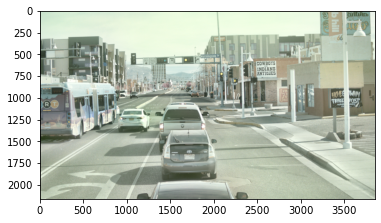

In [151]:
plt.imshow(input['target'].permute(1,2,0).numpy())

In [133]:
(np.array(targets) == 'torc_wk3').sum()

25844

In [134]:
# Compute samples weight (each sample should get its own weight)
class_sample_count = np.array([(targets == t).astype(int).sum() for t in sorted(set(targets))],dtype=float)
weight = 1. / class_sample_count
weight *= 1/weight.sum()
weight_map = {t:weight[i] for i,t in enumerate(sorted(set(targets)))}

In [135]:
samples_weight = torch.tensor([weight_map[t] for t in targets])

In [121]:
np.savez("/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files/val_weights.npz",
         samples_weight)

In [114]:
weight_map = {t:weight[i] for i,t in enumerate(sorted(set(targets)))}

In [100]:
weight_map

{'continental': 0.00011448196908986835,
 'torc_wk1': 0.00042283298097251583,
 'torc_wk2': 5.862351975612616e-05,
 'torc_wk3': 3.8693700665531654e-05}

In [98]:
sorted(set(targets))

['continental', 'torc_wk1', 'torc_wk2', 'torc_wk3']

In [97]:
weight * 1/weight.sum()

array([0.18039106, 0.66626465, 0.09237401, 0.06097028])

In [109]:
np.savez("/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files/train_weights.npz",samples_weight)

In [106]:
# Create sampler, dataset, loader
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [108]:
list(sampler)

[52792,
 42394,
 37629,
 21973,
 27101,
 40426,
 14878,
 14019,
 44166,
 30661,
 40138,
 39395,
 53089,
 1592,
 53064,
 11064,
 50985,
 6445,
 50738,
 18608,
 4488,
 45253,
 28051,
 45226,
 40292,
 24076,
 43686,
 38065,
 23681,
 37575,
 44004,
 3422,
 50748,
 47885,
 13060,
 7847,
 23765,
 39667,
 50615,
 4233,
 23931,
 33632,
 764,
 27816,
 49036,
 22338,
 2644,
 29231,
 40718,
 37264,
 19770,
 9834,
 36609,
 5774,
 46106,
 23710,
 8510,
 8957,
 29986,
 43471,
 4180,
 40943,
 14928,
 40143,
 17493,
 43051,
 3486,
 10371,
 45959,
 32131,
 36138,
 36475,
 25525,
 10032,
 47896,
 36726,
 5807,
 40779,
 34439,
 3561,
 48057,
 3740,
 51902,
 11132,
 35947,
 19093,
 39100,
 48323,
 5679,
 22736,
 42270,
 17519,
 14067,
 41768,
 808,
 23774,
 47192,
 42147,
 27730,
 18677,
 29130,
 7816,
 20132,
 45285,
 41575,
 33769,
 33415,
 9487,
 8530,
 49249,
 42951,
 12252,
 19772,
 37000,
 40674,
 26256,
 16838,
 25829,
 52410,
 14462,
 19151,
 32616,
 44119,
 45897,
 13377,
 1955,
 25090,
 16980,
 

In [ ]:
# Compute samples weight (each sample should get its own weight)
class_sample_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in targets])

In [8]:
X = np.load("/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files/algolux/train_sample_weights.npz")['arr_0']

In [9]:
X.shape

(54002,)

In [10]:
X

array([0.18039106, 0.18039106, 0.09237401, ..., 0.09237401, 0.09237401,
       0.09237401])

In [12]:
N = 6949
weights = np.ones(N) * 1/N
list(WeightedRandomSampler(weights, N, replacement=False))
np.savez("/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files/carla/val_weights.npz",weights)

[4561,
 2263,
 1762,
 6,
 1642,
 1753,
 3264,
 3550,
 3991,
 4249,
 331,
 4369,
 4555,
 4568,
 2516,
 3903,
 2056,
 3166,
 3961,
 269,
 4364,
 2387,
 1628,
 2489,
 1437,
 1083,
 2191,
 4455,
 500,
 3448,
 3894,
 778,
 3735,
 3336,
 2398,
 1386,
 3677,
 3496,
 982,
 384,
 4001,
 3469,
 4401,
 2176,
 145,
 2994,
 4078,
 4217,
 4282,
 4072,
 3153,
 4501,
 1249,
 3666,
 4252,
 3233,
 1089,
 867,
 2964,
 1224,
 4262,
 4091,
 1810,
 530,
 2860,
 3390,
 2465,
 4241,
 4193,
 2163,
 3102,
 4,
 697,
 2020,
 3008,
 4313,
 2076,
 1553,
 1905,
 149,
 390,
 870,
 509,
 486,
 2936,
 919,
 3596,
 2796,
 908,
 70,
 1274,
 1433,
 927,
 3923,
 1304,
 3019,
 24,
 1747,
 3966,
 589,
 828,
 3974,
 2529,
 2084,
 3695,
 992,
 3134,
 953,
 1876,
 1612,
 2603,
 1820,
 961,
 2251,
 2928,
 545,
 1464,
 2137,
 3483,
 4080,
 1908,
 4181,
 2467,
 1360,
 712,
 1005,
 3861,
 757,
 471,
 118,
 2405,
 2009,
 4102,
 2818,
 1869,
 4591,
 2422,
 2113,
 1043,
 2164,
 117,
 833,
 3231,
 3431,
 4115,
 696,
 3237,
 1524,
 548,

In [13]:
np.savez("/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/src/data/split_files/carla/val_weights.npz",weights)

In [7]:
weights

array([5.39607166e-05, 5.39607166e-05, 5.39607166e-05, ...,
       5.39607166e-05, 5.39607166e-05, 5.39607166e-05])